In [44]:
import re
import json
import operator
from bs4 import BeautifulSoup
from collections import Counter
from nltk.tokenize import TweetTokenizer
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import islice
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity as cosine

path_read = "../data/"
path_write = "../data/"

min_freq = 5 # retain the words appearing at least this number of times
oov_token = 0 # for out-of-vocabulary words

verbosity = 5


In [2]:
# ========== read and clean reviews ==========

with open(path_read + 'imdb_reviews.txt','r',encoding='utf-8') as file:
    reviews = file.readlines()

tokenizer = TweetTokenizer()

cleaned_reviews = []

for counter,rev in enumerate(reviews):
    rev = rev.lower()
    temp = BeautifulSoup(rev,'lxml')
    text = temp.get_text() # remove HTML formatting
    text = re.sub(' +',' ',text) # strip extra white space
    text = text.strip() # strip leading and trailing white space
    tokens = tokenizer.tokenize(text) # tokenize
    cleaned_reviews.append(tokens)
    if counter % round(len(reviews)/verbosity) == 0:
        print(counter, '/', len(reviews), 'reviews cleaned')

# ========== build vocab ==========

### fill the gap (create a list 'tokens' containing all the tokens in 'cleaned_reviews') ###


0 / 25000 reviews cleaned
5000 / 25000 reviews cleaned
10000 / 25000 reviews cleaned
15000 / 25000 reviews cleaned
20000 / 25000 reviews cleaned


In [5]:
cleaned_reviews[2][12] # There is still punctuation in the reviews, it that ok?

':'

In [ ]:
# Not what was asked

tokens = []
for (counter, rev) in enumerate(cleaned_reviews):
    for token in rev:
        if token not in tokens:
            tokens.append(token)
    if counter % round(len(cleaned_reviews)/verbosity) == 0:
            print(counter, '/', len(cleaned_reviews), 'reviews tokenized')
            

In [6]:
tokens = [token for rev in cleaned_reviews for token in rev] # flattening the list of lists cleaned_reviews
len(tokens)

6549271

In [7]:
counts = dict(Counter(tokens))

### fill the gap (filter the dictionary 'counts' by retaining only the words that appear at least 'min_freq' times)
counts = {k:v for k,v in counts.items() if v>=min_freq}

with open(path_write + 'counts.json', 'w') as file:
    json.dump(counts, file, sort_keys=True, indent=4)

print('counts saved to disk')

sorted_counts = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)


counts saved to disk


In [10]:
# assign to each word an index based on its frequency in the corpus
# the most frequent word will get index equal to 1
# 0 is reserved for out-of-vocabulary words
word_to_index = dict([(my_tuple[0],idx) for idx,my_tuple in enumerate(sorted_counts,1)])

# examples
word_to_index['the']
word_to_index["don't"]

with open(path_write + 'vocab.json', 'w') as file:
    json.dump(word_to_index, file, sort_keys=True, indent=4)

print('vocab saved to disk')


vocab saved to disk


In [13]:
# ========== transform each review into a list of word indexes ==========

reviews_ints = []

for i,rev in enumerate(cleaned_reviews):
    sublist = []
    ### fill the gaps (for the tokens that are not in 'word_to_index', use 'oov_token') ###
    for token in rev:
        if token not in word_to_index.keys(): # checking if the word is in the vocabulary 
            sublist.append(oov_token)
        else:
            sublist.append(word_to_index[token])
    reviews_ints.append(sublist)
    
    if i % round(len(cleaned_reviews)/verbosity) == 0: # Logging progress
        print(i, '/', len(cleaned_reviews), 'reviews converted')

with open(path_write + 'doc_ints.txt', 'w') as file:
    for rev in reviews_ints:
        file.write(' '.join([str(elt) for elt in rev]) + '\n')

print('reviews saved to disk')

0 / 25000 reviews converted
5000 / 25000 reviews converted
10000 / 25000 reviews converted
15000 / 25000 reviews converted
20000 / 25000 reviews converted
reviews saved to disk


In [322]:
def get_windows(seq,n):
    '''
    returns a sliding window (of width n) over data from the iterable
    taken from: https://stackoverflow.com/questions/6822725/rolling-or-sliding-window-iterator/6822773#6822773
    '''
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [306]:
def sample_examples(docs,max_window_size,n_windows):
    '''generate target,context pairs and negative examples'''
    windows = []

    for i,doc in enumerate(docs):
        ### fill the gaps (get windows of size 'window_size' from the current document. Sample 'window_size' uniformly in {1,...,max_window_size}) ###
        window_size = np.random.choice(max_window_size)+1
        windows.append(get_windows(doc, window_size))
        
    windows = [elt for sublist in windows for elt in sublist] # flatten
    windows = list(np.random.choice(windows,size=n_windows)) # select a subset
    
    ### fill the gap (sample n_negs*len(windows) negatives according to some probability distribution ###
    
    all_negs = list(np.random.choice(token_ints, p = neg_distr, size = n_negs*len(windows)))
    
    return windows,all_negs

In [317]:
def compute_dot_products(pos,negs,target):
    prods = Wc[pos+negs,] @ Wt[target,] # (n_pos+n_negs,d) X (d,) -> (n_pos+n_negs,)
    return prods

In [338]:
def compute_loss(prodpos,prodnegs):
    '''prodpos and prodnegs are numpy vectors containing the dot products of the context word vectors with the target word vector'''
    ### fill the gaps ###
    term_pos = [np.log(1+np.exp(-i)) for i in prodpos]
    term_negs = [np.log(1+np.exp(i)) for i in prodnegs]
    return np.sum(term_pos) + np.sum(term_negs)

In [421]:
def compute_gradients(pos,negs,target,prodpos,prodnegs):
    factors_pos = 1/(np.exp(prodpos)+1)
    factors_negs = 1/(np.exp(-prodnegs)+1)
    ### fill the gaps ### 
    
    partials_pos = - np.reshape(factors_pos,(len(factors_pos),1)) @ np.reshape(Wt[target,],(1,len(Wt[target,])))
    partials_negs = np.reshape(factors_negs,(len(factors_negs),1)) @ np.reshape(Wt[target,],(1,len(Wt[target,])))
    
        
    term_pos = np.reshape(factors_pos,(1,len(factors_pos))) @ (-Wc[pos,])
    term_negs = np.reshape(factors_negs,(1,len(factors_negs))) @ Wc[negs,]
    
    partial_target = np.sum(term_pos,axis=0) + np.sum(term_negs,axis=0)
    
    return partials_pos,partials_negs,partial_target

In [310]:
def my_cos_similarity(word1,word2):
    sim = cosine(Wt[vocab[word1],].reshape(1,-1),Wt[vocab[word2],].reshape(1,-1))
    return round(float(sim),4)

In [311]:
path_read = "../data/"
path_write = path_read

stpwds = set(stopwords.words('english'))

max_window_size = 5 # extends on both sides of the target word
n_windows = int(1e6) # number of windows to sample at each epoch
n_negs = 5 # number of negative examples to sample for each positive
d = 30 # dimension of the embedding space
n_epochs = 15
lr_0 = 0.025
decay = 1e-6

train = True

with open(path_read + 'doc_ints.txt', 'r') as file:
    docs = file.read().splitlines()

docs = [[int(eltt) for eltt in elt.split()] for elt in docs]

with open(path_read + 'vocab.json', 'r') as file:
    vocab = json.load(file)

vocab_inv = {v:k for k,v in vocab.items()}

with open(path_read + 'counts.json', 'r') as file:
    counts = json.load(file)

token_ints = range(1,len(vocab)+1)
neg_distr = [counts[vocab_inv[elt]] for elt in token_ints]
neg_distr = np.sqrt(neg_distr)
neg_distr = neg_distr/sum(neg_distr) # normalize

In [422]:
if train:
    
    total_its = 0
    
#     Wt = np.random.normal(size=(len(vocab)+1,d)) # + 1 is for the OOV token
#     Wc = np.random.normal(size=(len(vocab)+1,d))
    
    for epoch in range(n_epochs):
        
        windows,all_negs = sample_examples(docs,max_window_size,n_windows)
        print('training examples sampled')
        
        np.random.shuffle(windows)
#         print(len(windows))
        
        total_loss = 0
        
        with tqdm(total=len(windows),unit_scale=True,postfix={'loss':0.0,'lr':lr_0},desc="Epoch : %i/%i" % (epoch+1, n_epochs),ncols=50) as pbar:
            for i,w in enumerate(windows):
                
                target = w[int(len(w)/2)] # elt at the center
                pos = list(w)
                del pos[int(len(w)/2)] # all elts but the center one
#                 print(pos)
                
                negs = all_negs[n_negs*i:n_negs*(i+1)]
#                 print(negs)
                
                prods = compute_dot_products(pos,negs,target)
                prodpos = prods[0:len(pos),]
                prodnegs = prods[len(pos):(len(pos)+len(negs)),]
                
                partials_pos,partials_negs,partial_target = compute_gradients(pos,negs,target,prodpos,prodnegs)
                
                lr = lr_0 * 1/(1+decay*total_its)
                total_its += 1
                
                ### fill the gaps (perform the updates) ###
                Wt[target,] -= lr * partial_target
                Wc[pos,] -= lr * partials_pos
                Wc[negs,] -= lr * partials_negs
                
                total_loss += compute_loss(prodpos,prodnegs)
                pbar.set_postfix({'loss':total_loss/(i+1),'lr':lr})
                pbar.update(1)
                

    np.save(path_write + 'input_vecs',Wt,allow_pickle=False) # pickle disabled for portability reasons
    np.save(path_write + 'output_vecs',Wc,allow_pickle=False)
    
    print('word vectors saved to disk')

else:
    Wt = np.load(path_write + 'input_vecs.npy')
    Wc = np.load(path_write + 'output_vecs.npy')

Epoch : 1/15:   0%| | 58.0/1.00M [00:00<47:44, 349it/s, loss=3.94, lr=0.025]

training examples sampled


Epoch : 1/15:   5%| | 50.5k/1.00M [02:26<54:37, 290it/s, loss=3.22, lr=0.0238]   

KeyboardInterrupt: 

0.9046


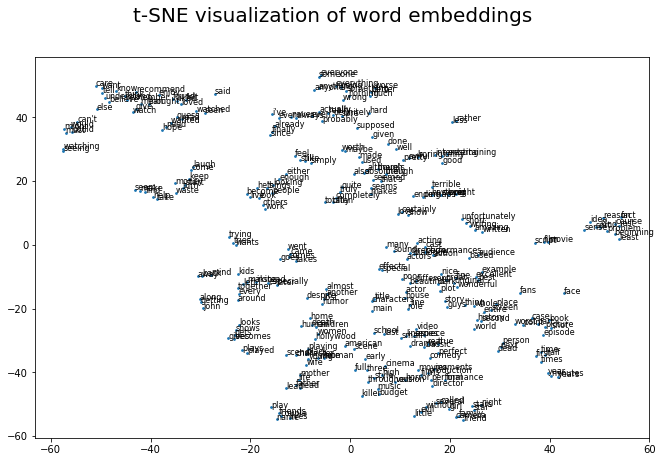

In [412]:
# ========== sanity checks ==========
%matplotlib inline
if train:

    # = = some similarities = = 
    ### fill the gaps (compute the cosine similarity between some (un)related words, like movie/film/banana ###
    print(my_cos_similarity("book","movie"))

    # = = visualization of most frequent tokens = =

    n_plot = 500
    mft = [vocab_inv[elt] for elt in range(1,n_plot+1)]

    # exclude stopwords and punctuation
    keep_idxs = [idx for idx,elt in enumerate(mft) if len(elt)>3 and elt not in stpwds]
    mft = [mft[idx] for idx in keep_idxs]
    keep_ints = [list(range(1,n_plot+1))[idx] for idx in keep_idxs]
    Wt_freq = Wt[keep_ints,]
    
    ### fill the gaps (perfom PCA (10D) followed by t-SNE (2D). For t-SNE, you can use a perplexity of 5.) ###
    ### for t-SNE, see https://lvdmaaten.github.io/tsne/#faq ###
    my_pca = PCA(n_components=10)
    my_tsne = TSNE(n_components=2,perplexity=5)

    my_pca_fit = my_pca.fit_transform(Wt_freq)
    my_tsne_fit = my_tsne.fit_transform(my_pca_fit)
    
    fig, ax = plt.subplots()
    X = my_tsne_fit[:,0]
    Y = my_tsne_fit[:,1]
    ax.scatter(X,Y ,s=3) ### fill the gap ###
    for x,y,token in zip(X, Y, mft): ### fill the gap ###
        ax.annotate(token, xy=(x,y), size=8)

    fig.suptitle('t-SNE visualization of word embeddings',fontsize=20)
    fig.set_size_inches(11,7)
    fig.savefig(path_write + 'word_embeddings.pdf',dpi=300)

In [416]:
print(my_cos_similarity("drama","thriller"))

0.9305
